<a href="https://colab.research.google.com/github/ShyamSundhar1411/My-ML-Notebooks/blob/master/Milestone%20Project/Milestone_Project_1_Food_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1:Food Vision Big

In [1]:
!pip install tensorflow==2.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-65ec8df7-a018-36bd-674d-716109a2c544)


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-31 18:15:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-31 18:15:10 (95.4 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [4]:
from helper_functions import unzip_data,walk_through_dir,plot_loss_curves,compare_historys,create_tensorboard_callback

## Importing Datasets using TDFS

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [6]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [7]:
(train_data,test_data,),ds_info = tfds.load(name = "food101",
  split = ["train","validation"],as_supervised = True,shuffle_files = True,
  with_info = True
) 

In [8]:
## Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [9]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
train_one_sample = train_data.take(1)

In [11]:
for image,label in train_one_sample:
  print(image.shape)
  print(image.dtype)
  

(512, 512, 3)
<dtype: 'uint8'>


In [12]:
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Visualization

(-0.5, 511.5, 511.5, -0.5)

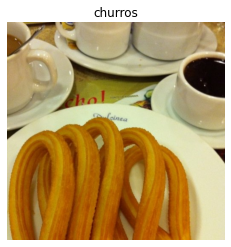

In [13]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Preprocessing Images

In [14]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

def preprocess_img(image,label,img_shape = 224):
  image = tf.image.resize(image,[img_shape,img_shape])
  return tf.cast(image,tf.float32)

ImportError: ignored

In [ ]:
preprocessed_img = preprocess_img(image,label)[0]

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\n")

## Batching Images

In [ ]:
train_data

In [ ]:
#Map Preprocessing function to training data and parallelize it
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
print(train_data)
print(test_data)

## Create Modelling Callbacks

In [ ]:
checkpoint_path = "model_checkpoints/cp.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = "val_acc",
    save_best_only = True,
    save_weights_only = True,
    verbose = 0
)

## Setting up mixed precision training

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") 

In [ ]:
mixed_precision.global_policy()

## Model 0 : Feature Extraction

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
input_shape = (224,224,3)

## Base Model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

## Functional Model
inputs = layers.Input(shape = input_shape,name = "input_shape")
x = base_model(inputs,training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(101)(x)
outputs = layers.Activation("softmax",dtype = tf.float32,name = "softmax_float32")(x)
model_0 = tf.keras.Model(inputs,outputs)
model_0.compile(loss = "categorical_crossentropy",optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [ ]:
for layer in model_0.layers[:10]:
  print(layer.name,layer.dtype,layer.dtype_policy)

In [ ]:
train_data

In [ ]:
history_0 = model_0.fit(train_data,
    epochs = 3,
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15*(len(test_data))),
    callbacks = [create_tensorboard_callback("training_logs","efficient_net_b0")]
)

In [ ]:
results_feature_extract_model = model_0.evaluate(test_data)
results_feature_extract_model